In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


In [30]:
!git clone https://github.com/yushijie0404/deepinvPnPPBCD

# 步骤 2: 进入项目目录（关键步骤）
%cd deepinvPnPPBCD

# 步骤 3: 安装依赖
!pip install -r requirements.txt

# 步骤 4: 添加当前目录到 Python 路径
import sys
sys.path.append('/content/drive/MyDrive/deepinvPnPPBCD')

# Add print statements to diagnose the error in mode_dot


fatal: destination path 'deepinvPnPPBCD' already exists and is not an empty directory.
/content/drive/MyDrive/deepinvPnPPBCD


In [31]:
import tensorly as tl
from tensorly.base import unfold

original_unfold = unfold

def new_unfold(tensor, mode):
    print(f"Type of tensor in unfold: {type(tensor)}")
    print(f"Shape of tensor in unfold: {tensor.shape if hasattr(tensor, 'shape') else 'N/A'}")
    return original_unfold(tensor, mode)

tl.base.unfold = new_unfold

In [16]:

import torch
import scipy.io as scio
import deepinv as dinv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from deepinv.optim.data_fidelity import L2
from deepinv.utils import get_freer_gpu
from pbcd import PBCDIteration
from models import L2pPrior, StiefelPrior, GSPnP, noise_estimate_batch_new

In [25]:
%cd /content/drive/MyDrive
sys.path.append('/content/drive/MyDrive/AnomalyDetectionDataset')

/content/drive/MyDrive


Selected GPU 0 with 14756 MiB free memory 


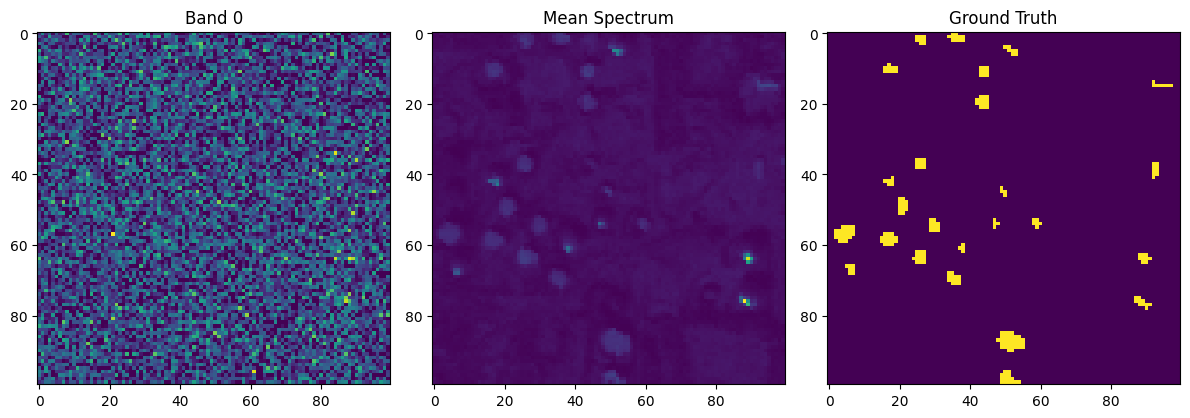

In [26]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
dataset_name = 'abu-urban-4'
noise_level_img = 0.03
data_path = f'AnomalyDetectionDataset/20241120/{dataset_name}_nl{int(noise_level_img*100):03d}.mat'
data = scio.loadmat(data_path, variable_names=['D_noise', 'amo_gt'])

D_noise = torch.tensor(data['D_noise'].astype('float32'), device=device)
D_noise = D_noise / D_noise.max()
amo_gt = torch.tensor(data['amo_gt'], device=device)

# Show sample data
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(D_noise[0].cpu().numpy())
plt.title('Band 0')
plt.subplot(132)
plt.imshow(np.mean(D_noise.cpu().numpy(), axis=0))
plt.title('Mean Spectrum')
plt.subplot(133)
plt.imshow(amo_gt.cpu().numpy())
plt.title('Ground Truth')
plt.tight_layout()
plt.show()

In [27]:
rank = 8
e_init = torch.randn(D_noise.shape[0], rank, device=device)
U, _, V = torch.linalg.svd(e_init, full_matrices=False)
e_init = U @ torch.diag(torch.ones(rank, device=device)) @ V

params_algo = {
    "noiselevelparams": 1,
    "delta": 5000000000000.0,
    "tau": 0.000000015,
    "alpha_S": 0.1,
    "alpha_E": 0.1,
    "alpha_Z": 0.09,
}
params_algo["tilde_alpha_Z"] = params_algo["delta"] / (params_algo["delta"] + params_algo["alpha_Z"])
params_algo["lambda"] = 1 / params_algo["tilde_alpha_Z"]

data_fidelity = L2()
prior_S = L2pPrior(l2_axis=1, l2p_p=0.1)
prior_E = StiefelPrior(rank=rank)
prior_Z = GSPnP(denoiser=dinv.models.GSDRUNet(in_channels=1, out_channels=1).to(device))
iterator = PBCDIteration(eigenmode=1, l2_axis=1)

S_init = torch.zeros_like(D_noise)
Z_init = torch.zeros(1, rank, *D_noise.shape[1:], device=device)
X = {"est": (S_init, e_init, Z_init), "cost": []}

In [29]:
max_iter = 10
for it in tqdm(range(max_iter)):
    X = iterator(
        X,
        data_fidelity,
        [prior_S, prior_E, prior_Z],
        params_algo,
        D_noise
    )

# [5] Results
S_final = X["est"][0]
S_map = torch.sum(S_final**2, dim=1)
ourdensity = S_map.cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(amo_gt.cpu().numpy())
plt.title('Ground Truth')
plt.subplot(132)
plt.imshow(ourdensity)
plt.title('Detected Anomalies')
plt.subplot(133)
plt.imshow(np.abs(ourdensity - amo_gt.cpu().numpy()))
plt.title('Difference')
plt.tight_layout()
plt.show()

Path("results").mkdir(exist_ok=True)
save_path = f'results/{dataset_name}_result_nl{int(noise_level_img*100):03d}.mat'
scio.savemat(save_path, {
    'params_algo': params_algo,
    'ourdensity': ourdensity,
    'amo_gt': amo_gt.cpu().numpy()
})
print(f"Results saved to {save_path}")

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: transpose() received an invalid combination of arguments - got (list), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)
